# Import Dependencies

In [67]:
# from utils import * # backend file
# from dotenv import load_dotenv # load config
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.covariance import ShrunkCovariance,\
	empirical_covariance, log_likelihood
from scipy import linalg
from sklearn.model_selection import GridSearchCV
import random
from sklearn.preprocessing import QuantileTransformer
from pypfopt import black_litterman, risk_models, \
    BlackLittermanModel, plotting, DiscreteAllocation, \
    EfficientFrontier, objective_functions
import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from joblib import dump, load
from scipy.stats import linregress
from scipy.optimize import minimize
import yfinance as yf
import pandas as pd
import numpy as np

In [68]:
# load_dotenv()

In [69]:
# username = int(os.getenv('MT5_USERNAME'))
# password = os.getenv('MT5_PASSWORD')
# server = os.getenv('MT5_SERVER')
# api_key = os.getenv('BINANCE_API')
# api_secret = os.getenv('BINANCE_SECRET_API')

In [70]:
# datafetcher = DataFetcher(username, password, server, api_key, api_secret)
# dataprocessor = DataProcessor()

In [71]:
# datafetcher.get_investor_data()

# Instruments List

In [72]:
tickers_dict = {
    "bond_etfs": ["MUB", "BND", "SCHZ", "GOVT", "SPIB", "BSV","TIP","VCSH","AGG","BIV","FBND","BOND","TLT"], 
    "stock_etfs": ["PFF", "SCHD", "IYR", "SDY","DGRO","VOO","SCHB","SCHV","QLD","IYW","IYK"],
    "cash_equivalents": ['SHV','BIL']
}

# Historical Bars

In [73]:
def yfinance_adj_close(tickers, start=None, end=None, period='1mo', interval='1d'):
    if isinstance(tickers, str):
        tickers = [tickers]

    try:
        if start and end:
            print(f"Fetching data for {tickers} from {start} to {end} with interval '{interval}'")
            data = yf.download(tickers, start=start, end=end, interval=interval)
        else:
            print(f"Fetching data for {tickers} with period '{period}' and interval '{interval}'")
            data = yf.download(tickers, period=period, interval=interval)
        
        if "Adj Close" in data.columns:
            return data["Adj Close"]
        else:
            print("Warning: 'Adj Close' data not available, returning full dataset.")
        return data
    except Exception as e:
        print(f"Error while fetching data: {e}")
        return None

In [74]:
all_data = {}
start_date = '2019-01-01'
end_date = '2024-01-01'

for category, tickers in tickers_dict.items():
    print(f"Fetching data for category: {category}")
    all_data[category] = yfinance_adj_close(tickers, start=start_date, end=end_date)

df = pd.concat(all_data.values(), axis=1)
df.ffill(inplace=True)
df.bfill(inplace=True)
df

Fetching data for category: bond_etfs
Fetching data for ['MUB', 'BND', 'SCHZ', 'GOVT', 'SPIB', 'BSV', 'TIP', 'VCSH', 'AGG', 'BIV', 'FBND', 'BOND', 'TLT'] from 2019-01-01 to 2024-01-01 with interval '1d'


[                       0%%                      ]

[*********************100%%**********************]  13 of 13 completed
[*************         27%%                      ]  3 of 11 completed

Fetching data for category: stock_etfs
Fetching data for ['PFF', 'SCHD', 'IYR', 'SDY', 'DGRO', 'VOO', 'SCHB', 'SCHV', 'QLD', 'IYW', 'IYK'] from 2019-01-01 to 2024-01-01 with interval '1d'


[*********************100%%**********************]  11 of 11 completed
[*********************100%%**********************]  2 of 2 completed

Fetching data for category: cash_equivalents
Fetching data for ['SHV', 'BIL'] from 2019-01-01 to 2024-01-01 with interval '1d'


Ticker,AGG,BIV,BND,BOND,BSV,FBND,GOVT,MUB,SCHZ,SPIB,...,IYW,PFF,QLD,SCHB,SCHD,SCHV,SDY,VOO,BIL,SHV
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,90.974007,68.054298,67.512184,83.736893,69.351891,39.601402,21.959682,94.844856,19.605186,27.773346,...,38.811607,25.145721,16.744156,8.360729,13.659786,12.463302,76.077927,209.174652,80.134148,96.215034
2019-01-03,91.349594,68.396698,67.775864,84.095108,69.510635,39.780998,22.083393,95.114586,19.682516,27.848934,...,37.014858,25.189379,15.621118,8.169668,13.392232,12.256253,75.119698,204.181519,80.160423,96.249916
2019-01-04,91.076385,68.087715,67.571732,83.793900,69.334251,39.764687,21.968517,94.862267,19.609056,27.773346,...,38.697792,25.458668,17.021206,8.449988,13.761573,12.614802,76.865074,210.920898,80.169205,96.276085
2019-01-07,90.922768,68.020882,67.469673,83.696198,69.254898,39.715714,21.924330,94.853561,19.593596,27.756546,...,39.024704,25.538734,17.365042,8.525297,13.854636,12.682976,77.173080,212.503387,80.169205,96.276085
2019-01-08,90.854454,67.912338,67.384590,83.639244,69.193146,39.707554,21.880154,94.783958,19.593596,27.756546,...,39.458149,25.604231,17.711353,8.613157,13.985508,12.778924,78.131332,214.567932,80.169205,96.267342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,95.252739,73.627914,70.975830,88.099106,74.551147,44.018288,22.327000,105.372818,22.000568,31.432369,...,122.373444,29.518303,75.462852,18.322609,24.796144,22.332956,121.347046,431.015472,87.204681,105.034904
2023-12-26,95.445488,73.647232,71.043556,88.241959,74.502655,44.056496,22.346436,105.411743,22.024229,31.441971,...,123.022232,29.537209,76.340912,18.418364,24.917103,22.445116,121.952705,432.807678,87.223793,105.054001
2023-12-27,96.052696,74.169136,71.498276,88.737167,74.696594,44.320316,22.472740,105.839882,22.161467,31.586025,...,123.022232,29.678988,76.630280,18.441479,24.936716,22.477163,122.177391,433.599823,87.223793,105.054001


## Historical Market Cap

In [75]:
caps_dict = {'MUB': 30.6e9, 
    'BND': 89e9,
    'SCHZ': 10.6e9,
    'GOVT': 20.1e9,
    'SPIB': 15.3e9,
    'BSV': 50e9,
    'TIP': 25.9e9,
    'VCSH': 47e9,
    'PFF': 12e9,
    'SCHD': 47e9,
    'IYR': 3.8e9,
    'SDY': 22.6e9,
    'DGRO': 24e9,
    'VOO': 317e9,
    'AGG': 92e9,
    'BIV': 19e9,
    'FBND': 6e9,
    'BOND': 4.9e9,
    'SCHB': 33.4e9,
    'TLT': 59.2e9,
    'SCHV':9.6e9,
    'QLD': 5.5e9,
    'IYW': 8.4e9,
    'IYK': 1.8e9
    }
caps_dict

{'MUB': 30600000000.0,
 'BND': 89000000000.0,
 'SCHZ': 10600000000.0,
 'GOVT': 20100000000.0,
 'SPIB': 15300000000.0,
 'BSV': 50000000000.0,
 'TIP': 25900000000.0,
 'VCSH': 47000000000.0,
 'PFF': 12000000000.0,
 'SCHD': 47000000000.0,
 'IYR': 3800000000.0,
 'SDY': 22600000000.0,
 'DGRO': 24000000000.0,
 'VOO': 317000000000.0,
 'AGG': 92000000000.0,
 'BIV': 19000000000.0,
 'FBND': 6000000000.0,
 'BOND': 4900000000.0,
 'SCHB': 33400000000.0,
 'TLT': 59200000000.0,
 'SCHV': 9600000000.0,
 'QLD': 5500000000.0,
 'IYW': 8400000000.0,
 'IYK': 1800000000.0}

In [76]:
ticker = "^IRX"

start_date = "2019-01-01"
end_date = "2024-01-01"

rf = yf.download(ticker, start=start_date, end=end_date)
rf = rf[['Adj Close']]
rf = rf.rename(columns={'Adj Close': 'rf'})
rf

[*********************100%%**********************]  1 of 1 completed


,rf
Date,
2019-01-02,2.365
2019-01-03,2.355
2019-01-04,2.358
2019-01-07,2.353
2019-01-08,2.400
...,...
2023-12-22,5.208
2023-12-26,5.203
2023-12-27,5.235


The displayed code retrieves historical risk-free rate data from Yahoo Finance using the ^IRX ticker, which typically represents the 13-week Treasury bill yield. Here's a breakdown:

Code Details:
Ticker and Date Range:

ticker = "^IRX": Represents the risk-free rate.
start_date = "2019-01-01", end_date = "2024-01-01": Specifies the time range for historical data.

In [77]:
rolling_rf = rf.rolling(window=252).mean()
rolling_rf

,rf
Date,
2019-01-02,NaN
2019-01-03,NaN
2019-01-04,NaN
2019-01-07,NaN
2019-01-08,NaN
...,...
2023-12-22,5.023583
2023-12-26,5.027532
2023-12-27,5.031667


# Asset Allocation

## VCV Estimation

In [78]:
selected_tickers = tickers_dict['bond_etfs'] + tickers_dict['stock_etfs']

filtered_df = df[selected_tickers]
filtered_df

Ticker,MUB,BND,SCHZ,GOVT,SPIB,BSV,TIP,VCSH,AGG,BIV,...,SCHD,IYR,SDY,DGRO,VOO,SCHB,SCHV,QLD,IYW,IYK
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,94.844856,67.512184,19.605186,21.959682,27.773346,69.351891,90.961311,66.630173,90.974007,68.054298,...,13.659786,62.579845,76.077927,28.828924,209.174652,8.360729,12.463302,16.744156,38.811607,31.224621
2019-01-03,95.114586,67.775864,19.682516,22.083393,27.848934,69.510635,91.492050,66.758301,91.349594,68.396698,...,13.392232,62.981007,75.119698,28.149981,204.181519,8.169668,12.256253,15.621118,37.014858,30.830671
2019-01-04,94.862267,67.571732,19.609056,21.968517,27.773346,69.334251,91.301262,66.578903,91.076385,68.087715,...,13.761573,63.655277,76.865074,28.985609,210.920898,8.449988,12.614802,17.021206,38.697792,31.695005
2019-01-07,94.853561,67.469673,19.593596,21.924330,27.756546,69.254898,91.243271,66.553276,90.922768,68.020882,...,13.854636,64.295425,77.173080,29.107462,212.503387,8.525297,12.682976,17.365042,39.024704,31.830238
2019-01-08,94.783958,67.384590,19.593596,21.880154,27.756546,69.193146,91.317902,66.519104,90.854454,67.912338,...,13.985508,65.464729,78.131332,29.359888,214.567932,8.613157,12.778924,17.711353,39.458149,32.215359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,105.372818,70.975830,22.000568,22.327000,31.432369,74.551147,104.905838,74.429245,95.252739,73.627914,...,24.796144,89.244858,121.347046,52.629528,431.015472,18.322609,22.332956,75.462852,122.373444,62.077301
2023-12-26,105.411743,71.043556,22.024229,22.346436,31.441971,74.502655,104.964439,74.429245,95.445488,73.647232,...,24.917103,89.923187,121.952705,52.885155,432.807678,18.418364,22.445116,76.340912,123.022232,62.388428
2023-12-27,105.839882,71.498276,22.161467,22.472740,31.586025,74.696594,105.442970,74.583565,96.052696,74.169136,...,24.936716,90.395073,122.177391,52.963806,433.599823,18.441479,22.477163,76.630280,123.022232,62.552177


In [79]:
def return_from_prices(prices, log_returns = False):
    if log_returns:
        returns = np.log(1 + prices.pct_change()).dropna(how = 'all')
    else:
        returns = prices.pct_change().dropna(how = 'all')
    return returns

In [80]:
log_returns = return_from_prices(filtered_df, log_returns=True)
log_returns.dropna(inplace=True)
log_returns

Ticker,MUB,BND,SCHZ,GOVT,SPIB,BSV,TIP,VCSH,AGG,BIV,...,SCHD,IYR,SDY,DGRO,VOO,SCHB,SCHV,QLD,IYW,IYK
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-03,0.002840,0.003898,0.003937,0.005618,0.002718,0.002286,0.005818,0.001921,0.004120,0.005019,...,-0.019781,0.006390,-0.012675,-0.023833,-0.024160,-0.023117,-0.016752,-0.069426,-0.047400,-0.012697
2019-01-04,-0.002656,-0.003016,-0.003739,-0.005215,-0.002718,-0.002541,-0.002087,-0.002691,-0.002995,-0.004528,...,0.027205,0.010649,0.022969,0.029253,0.032474,0.033737,0.028835,0.085836,0.044463,0.027649
2019-01-07,-0.000092,-0.001512,-0.000789,-0.002013,-0.000605,-0.001145,-0.000635,-0.000385,-0.001688,-0.000982,...,0.006740,0.010006,0.003999,0.004195,0.007475,0.008873,0.005390,0.019999,0.008412,0.004258
2019-01-08,-0.000734,-0.001262,0.000000,-0.002017,0.000000,-0.000892,0.000818,-0.000514,-0.000752,-0.001597,...,0.009402,0.018023,0.012340,0.008635,0.009668,0.010253,0.007537,0.019747,0.011046,0.012027
2019-01-09,-0.001102,0.001388,-0.000197,0.000000,0.002418,0.000892,0.001180,0.002181,0.000845,0.001843,...,0.000831,-0.001304,0.001313,0.002665,0.004610,0.005329,0.000790,0.014834,0.010196,-0.002833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,0.000832,-0.000668,-0.000645,-0.000870,0.000611,0.000716,-0.001953,0.000531,-0.001314,0.000197,...,0.006083,0.003310,0.004114,0.003368,0.002323,0.002165,0.004170,0.002781,0.001306,0.005343
2023-12-26,0.000369,0.000954,0.001075,0.000870,0.000305,-0.000651,0.000558,0.000000,0.002022,0.000262,...,0.004866,0.007572,0.004979,0.004845,0.004149,0.005212,0.005010,0.011568,0.005288,0.004999
2023-12-27,0.004053,0.006380,0.006212,0.005636,0.004571,0.002600,0.004549,0.002071,0.006342,0.007062,...,0.000787,0.005234,0.001841,0.001486,0.001829,0.001254,0.001427,0.003783,0.000000,0.002621


### Scaling

In [81]:
scaler = QuantileTransformer(output_distribution='uniform')
scaled_df = pd.DataFrame(scaler.fit_transform(filtered_df), columns=filtered_df.columns, index=filtered_df.index)

print(scaled_df)


Ticker           MUB       BND      SCHZ      GOVT      SPIB       BSV  \
Date                                                                     
2019-01-02  0.011840  0.084084  0.011933  0.208741  0.004004  0.007751   
2019-01-03  0.019056  0.108188  0.019995  0.260247  0.007007  0.014247   
2019-01-04  0.014073  0.087833  0.013013  0.215461  0.004004  0.005005   
2019-01-07  0.013013  0.080256  0.008509  0.190157  0.002002  0.001001   
2019-01-08  0.005305  0.071280  0.008509  0.171672  0.002002  0.000000   
...              ...       ...       ...       ...       ...       ...   
2023-12-22  0.741634  0.425025  0.591950  0.342665  0.640973  0.630569   
2023-12-26  0.744728  0.427883  0.594389  0.349850  0.642175  0.626745   
2023-12-27  0.771734  0.452417  0.605345  0.384347  0.657488  0.640282   
2023-12-28  0.757271  0.440364  0.599100  0.371409  0.656325  0.636927   
2023-12-29  0.750268  0.433088  0.596656  0.360371  0.655239  0.639623   

Ticker           TIP      VCSH       

In [82]:
base_X_train = scaled_df.loc[:'2021-01-01']
base_X_test = scaled_df.loc['2021-01-01':]

In [83]:
noOfFeatures, noOfSamples = 24, 1489
np.random.seed(42)

colorMatrix = np.random.randn(noOfFeatures, noOfFeatures)
X_train = np.dot(base_X_train, colorMatrix)
X_test = np.dot(base_X_test, colorMatrix)

In [84]:
# defining a Spanning range of all possible shrinkage coefficient values
shrinkageFactor = np.logspace(-2, 0, 32)
negative_logliks = [
	-ShrunkCovariance(shrinkage=s).fit(X_train).score(X_test)\
for s in shrinkageFactor]
realCovariance = np.dot(colorMatrix.T, colorMatrix)
empiricalCovariance = empirical_covariance(X_train)
logRealLikelihood = - \
	log_likelihood(empiricalCovariance, linalg.inv(realCovariance))

# GridSearch method for an optimal shrinkage coefficient
tunedParameters = [{"shrinkage": shrinkageFactor}]
cv = GridSearchCV(ShrunkCovariance(), tunedParameters)
cv.fit(X_train)

GridSearchCV(estimator=ShrunkCovariance(),
             param_grid=[{'shrinkage': array([0.01      , 0.01160155, 0.0134596 , 0.01561523, 0.01811609,
       0.02101748, 0.02438354, 0.02828869, 0.03281928, 0.03807546,
       0.04417345, 0.05124806, 0.05945571, 0.06897785, 0.08002502,
       0.09284145, 0.10771051, 0.12496091, 0.14497407, 0.16819243,
       0.19512934, 0.22638034, 0.26263635, 0.30469896, 0.35349811,
       0.41011271, 0.47579443, 0.55199543, 0.64040043, 0.74296395,
       0.86195357, 1.        ])}])

In [85]:
optimal_shrinkage_coef = cv.best_estimator_.shrinkage
optimal_shrinkage_coef

0.013459603241553642

In [86]:
from pypfopt.risk_models import CovarianceShrinkage

class CustomCovarianceShrinkage(CovarianceShrinkage):
    def shrunk_covariance(self, delta=0.2):
        return super().shrunk_covariance(delta=optimal_shrinkage_coef)
    
cov_matrix = CustomCovarianceShrinkage(log_returns, True, 252, True).ledoit_wolf()
cov_matrix

Ticker,MUB,BND,SCHZ,GOVT,SPIB,BSV,TIP,VCSH,AGG,BIV,...,SCHD,IYR,SDY,DGRO,VOO,SCHB,SCHV,QLD,IYW,IYK
Ticker,,,,,,,,,,,,,,,,,,,,,
MUB,0.004278,0.002702,0.002631,0.001435,0.002511,0.000971,0.001614,0.001898,0.002506,0.002300,...,0.003685,0.006509,0.003931,0.004093,0.004370,0.004554,0.004162,0.008738,0.004757,0.003850
BND,0.002702,0.005078,0.004232,0.003210,0.003064,0.001391,0.003305,0.001912,0.004146,0.003886,...,0.001634,0.004638,0.001744,0.002061,0.002602,0.002777,0.002031,0.006735,0.003605,0.002248
SCHZ,0.002631,0.004232,0.004971,0.003286,0.002885,0.001395,0.003333,0.001864,0.004130,0.003810,...,0.001201,0.004355,0.001494,0.001579,0.002160,0.002344,0.001638,0.005633,0.002943,0.002022
GOVT,0.001435,0.003210,0.003286,0.004201,0.002093,0.001267,0.003063,0.001234,0.003250,0.003384,...,-0.002870,-0.000350,-0.002747,-0.002659,-0.002244,-0.002177,-0.002740,-0.003101,-0.001777,-0.001645
SPIB,0.002511,0.003064,0.002885,0.002093,0.003914,0.001304,0.002400,0.002274,0.002894,0.003158,...,0.003098,0.005740,0.003029,0.003396,0.003908,0.004105,0.003428,0.009235,0.004895,0.003043
BSV,0.000971,0.001391,0.001395,0.001267,0.001304,0.001379,0.001298,0.001001,0.001322,0.001556,...,0.000180,0.001433,0.000206,0.000299,0.000508,0.000529,0.000319,0.001531,0.000770,0.000340
TIP,0.001614,0.003305,0.003333,0.003063,0.002400,0.001298,0.005508,0.001516,0.003322,0.003307,...,0.000038,0.003091,0.000270,0.000464,0.001093,0.001288,0.000652,0.003547,0.001845,0.000726
VCSH,0.001898,0.001912,0.001864,0.001234,0.002274,0.001001,0.001516,0.002450,0.001764,0.002026,...,0.002433,0.004360,0.002374,0.002582,0.002942,0.003052,0.002710,0.006571,0.003453,0.002322
AGG,0.002506,0.004146,0.004130,0.003250,0.002894,0.001322,0.003322,0.001764,0.004801,0.003815,...,0.001045,0.004186,0.001412,0.001531,0.002126,0.002368,0.001536,0.005722,0.003033,0.001912


## Black-Litterman Approach

In [87]:
target_prices = pd.read_excel("target_price (1).xlsx", sheet_name="Sheet1", index_col=0)
target_prices = target_prices[['Target Price']]
columns_to_select = filtered_df.columns
target_prices = target_prices[target_prices.index.isin(columns_to_select)]
target_series = target_prices['Target Price']
target_series

Ticker
MUB     109.52
BND      77.67
SCHZ     48.95
GOVT     24.75
SPIB     34.69
BSV      79.24
TIP     117.10
VCSH     79.69
AGG     104.30
BIV      82.57
FBND     48.62
BOND     95.95
TLT     124.40
PFF      31.15
SCHD     83.17
IYR      73.53
SDY     122.40
DGRO     59.96
VOO     538.60
SCHB     67.26
SCHV     69.75
QLD     133.80
IYW     229.40
IYK      96.82
Name: Target Price, dtype: float64

In [88]:
start_date = '2019-01-01'
end_date = '2024-01-01'

market_prices = yf.download("SPY", start=start_date, end=end_date)["Adj Close"]
market_prices.head()

[*********************100%%**********************]  1 of 1 completed


Date
2019-01-02    228.403610
2019-01-03    222.953308
2019-01-04    230.421295
2019-01-07    232.238052
2019-01-08    234.420013
Name: Adj Close, dtype: float64

In [89]:
S = cov_matrix
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

3.339773172183515

In [90]:
market_prices.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 1258 entries, 2019-01-02 to 2023-12-29
Series name: Adj Close
Non-Null Count  Dtype  
--------------  -----  
1258 non-null   float64
dtypes: float64(1)
memory usage: 19.7 KB


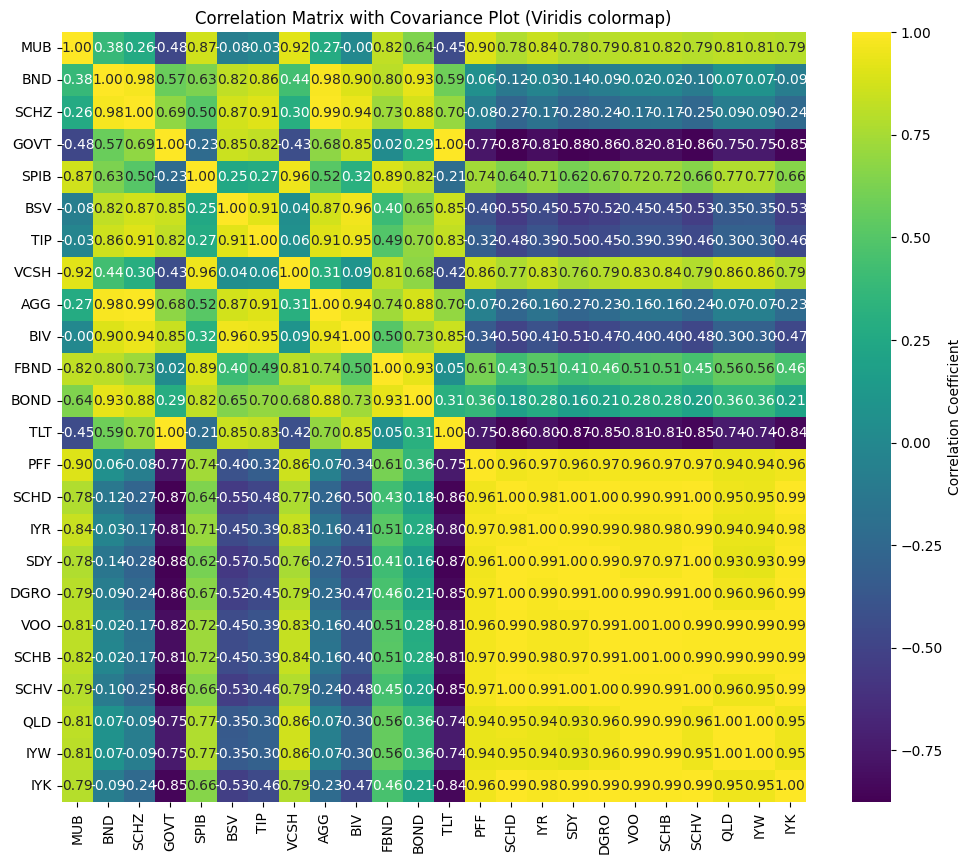

In [91]:
corr_matrix = np.corrcoef(S)

plt.figure(figsize=(12, 10))

sns.heatmap(corr_matrix, annot=True, cmap='viridis', fmt='.2f', 
            xticklabels=S.columns, yticklabels=S.columns,
            cbar_kws={'label': 'Correlation Coefficient'});

plt.title("Correlation Matrix with Covariance Plot (Viridis colormap)")
plt.show()

In [92]:
market_prior = black_litterman.market_implied_prior_returns(caps_dict, delta, S)
market_prior

Ticker
MUB     0.031634
BND     0.031219
SCHZ    0.030309
GOVT    0.021934
SPIB    0.031428
BSV     0.023291
TIP     0.027579
VCSH    0.028125
AGG     0.030340
BIV     0.028374
FBND    0.034866
BOND    0.030577
TLT     0.023953
PFF     0.067402
SCHD    0.086173
IYR     0.097024
SDY     0.087776
DGRO    0.090050
VOO     0.096796
SCHB    0.097652
SCHV    0.089942
QLD     0.189452
IYW     0.112056
IYK     0.076126
dtype: float64

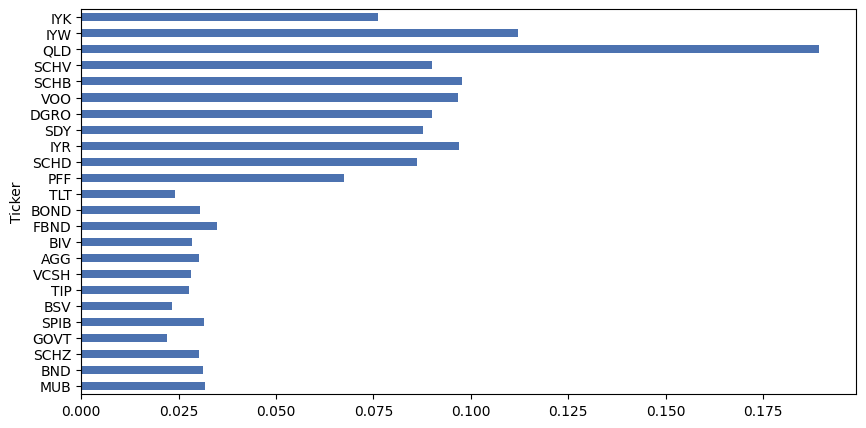

In [93]:
market_prior.plot.barh(figsize=(10,5));

In [94]:
last_row = filtered_df.iloc[-1]
sorted_target = target_series.reindex(last_row.index)
expt_returns = (sorted_target - last_row) / last_row
expt_returns.to_dict()

{'MUB': 0.038206824028530206,
 'BND': 0.09148942370444121,
 'SCHZ': 1.2187390830581513,
 'GOVT': 0.10563639798189266,
 'SPIB': 0.10027756378930233,
 'BSV': 0.060962428399317474,
 'TIP': 0.11551205813137115,
 'VCSH': 0.06791353001786954,
 'AGG': 0.09034801656146133,
 'BIV': 0.11851318751528274,
 'FBND': 0.10082616367202504,
 'BOND': 0.08584458532469681,
 'TLT': 0.3046949105129304,
 'PFF': 0.05663068041245646,
 'SCHD': 2.341813839076362,
 'IYR': -0.1817654844574291,
 'SDY': 0.002623660642109394,
 'DGRO': 0.13314554743340512,
 'VOO': 0.24528734081504847,
 'SCHB': 2.6590055268568515,
 'SCHV': 2.1049203984517972,
 'QLD': 0.7644257226526561,
 'IYW': 0.8722990386414001,
 'IYK': 0.542095483998913}

In [95]:
viewdict = expt_returns
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

In [96]:
def calculate_confidence(views):
    if abs(views) > 0.3:
        return random.choice([0.7, 0.8, 0.9])
    elif abs(views) > 0.1:
        return random.choice([0.4, 0.5, 0.6])
    else:
        return random.choice([0.1, 0.2, 0.3])
    
confidences = {ticker: calculate_confidence(return_value) for ticker, return_value in viewdict.items()}
confidences = list(confidences.values())
print(confidences)

[0.1, 0.2, 0.8, 0.6, 0.5, 0.1, 0.6, 0.3, 0.2, 0.4, 0.4, 0.3, 0.9, 0.3, 0.7, 0.5, 0.3, 0.6, 0.4, 0.9, 0.9, 0.9, 0.9, 0.8]


In [97]:
bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict, omega="idzorek", view_confidences=confidences)

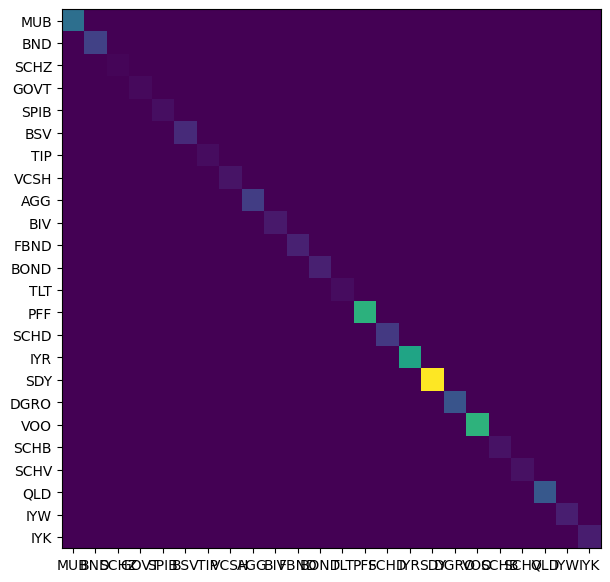

In [98]:

fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(bl.omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

In [99]:
np.diag(bl.omega)

array([1.92529572e-03, 1.01557717e-03, 6.21373338e-05, 1.40027926e-04,
       1.95703056e-04, 6.20632836e-04, 1.83594560e-04, 2.85821445e-04,
       9.60231284e-04, 3.53062314e-04, 4.75946336e-04, 4.73456308e-04,
       1.72784884e-04, 3.37788935e-03, 8.72064586e-04, 3.07522821e-03,
       5.27189187e-03, 1.37816063e-03, 3.40794894e-03, 2.62135571e-04,
       2.35847439e-04, 1.44702129e-03, 4.41394632e-04, 4.29454660e-04])

In [100]:
intervals = []
for confidence in confidences:
    if confidence >= 0.7:
        interval = (confidence - 0.1, confidence + 0.1)
    elif 0.4 <= confidence <= 0.6:
        interval = (confidence - 0.05, confidence + 0.05)
    else:
        interval = (confidence - 0.03, confidence + 0.03)
    
    interval = (max(0, interval[0]), min(1, interval[1]))
    intervals.append(interval)

In [101]:
variances = []
for lb, ub in intervals:
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)

print(variances)
omega = np.diag(variances)

[0.0009, 0.0009, 0.009999999999999995, 0.0025000000000000044, 0.002500000000000002, 0.0009, 0.0025000000000000044, 0.0008999999999999982, 0.0009, 0.0024999999999999988, 0.0024999999999999988, 0.0008999999999999982, 0.009999999999999995, 0.0008999999999999982, 0.009999999999999995, 0.002500000000000002, 0.0008999999999999982, 0.0025000000000000044, 0.0024999999999999988, 0.009999999999999995, 0.009999999999999995, 0.009999999999999995, 0.009999999999999995, 0.009999999999999995]


In [102]:
bl = BlackLittermanModel(S, pi="market", market_caps=caps_dict, risk_aversion=delta,
                        absolute_views=viewdict, omega=omega)

In [103]:
ret_bl = bl.bl_returns()
ret_bl

Ticker
MUB     0.046534
BND     0.071727
SCHZ    0.067156
GOVT    0.028675
SPIB    0.066787
BSV     0.022943
TIP     0.052892
VCSH    0.044092
AGG     0.062831
BIV     0.058974
FBND    0.075614
BOND    0.061866
TLT     0.066049
PFF     0.135239
SCHD    0.297746
IYR     0.172039
SDY     0.220203
DGRO    0.292617
VOO     0.351293
SCHB    0.364126
SCHV    0.296205
QLD     0.915908
IYW     0.503516
IYK     0.238561
dtype: float64

In [104]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(viewdict)], 
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
Ticker,,,
MUB,0.031634,0.046534,0.038207
BND,0.031219,0.071727,0.091489
SCHZ,0.030309,0.067156,1.218739
GOVT,0.021934,0.028675,0.105636
SPIB,0.031428,0.066787,0.100278
BSV,0.023291,0.022943,0.060962
TIP,0.027579,0.052892,0.115512
VCSH,0.028125,0.044092,0.067914
AGG,0.030340,0.062831,0.090348


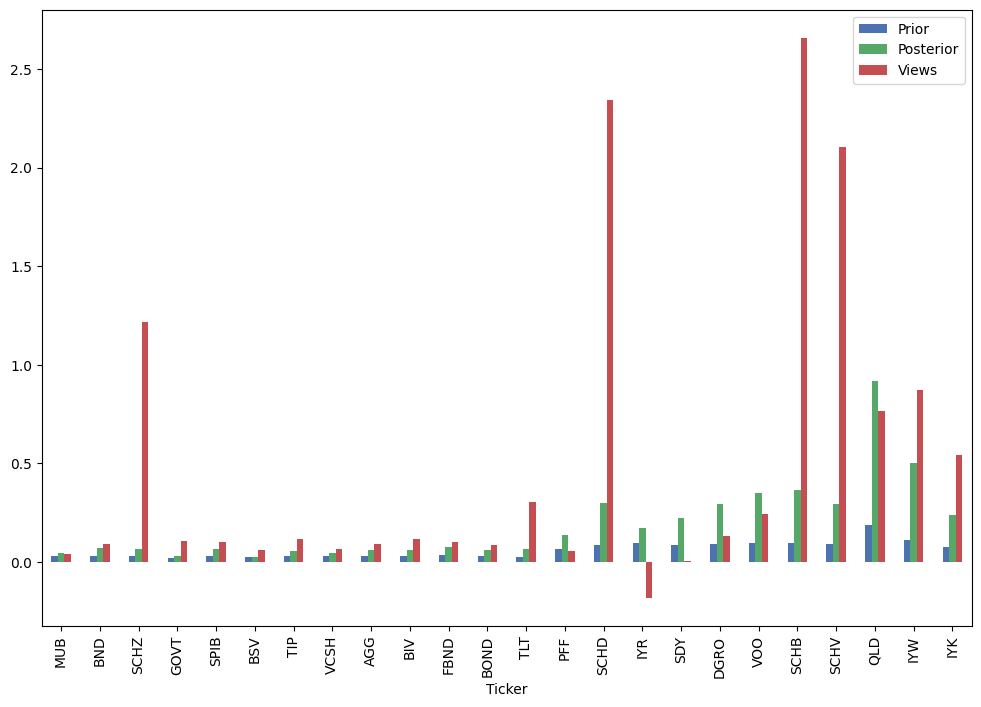

In [105]:
rets_df.plot.bar(figsize=(12,8));

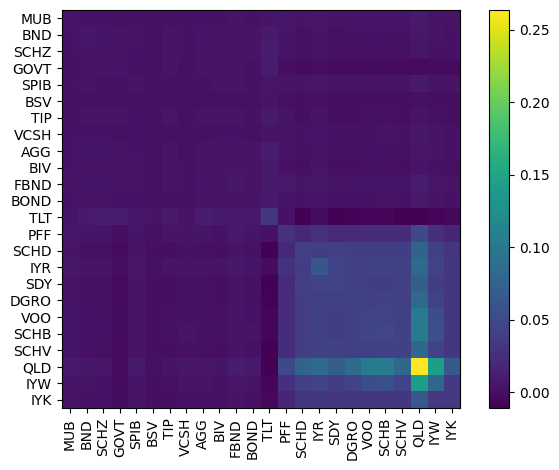

In [106]:
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

In [107]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_constraint(lambda w: w >= 0.0)
ef.add_constraint(lambda w: w <= 0.10)
bond_etfs = [0, 1, 2, 3, 4, 5, 6, 7]
stock_etfs = [8, 9, 10, 11, 12, 13]
ef.add_constraint(lambda w: sum(w[i] for i in bond_etfs) >= 0.6)
ef.add_constraint(lambda w: sum(w[i] for i in stock_etfs) <= 0.3)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights

OrderedDict([('MUB', 0.07253),
             ('BND', 0.08297),
             ('SCHZ', 0.08139),
             ('GOVT', 0.06827),
             ('SPIB', 0.08065),
             ('BSV', 0.0654),
             ('TIP', 0.0763),
             ('VCSH', 0.07247),
             ('AGG', 0.0),
             ('BIV', 0.0),
             ('FBND', 0.0),
             ('BOND', 0.0),
             ('TLT', 0.0),
             ('PFF', 0.0),
             ('SCHD', 0.03143),
             ('IYR', 0.0),
             ('SDY', 0.0),
             ('DGRO', 0.02771),
             ('VOO', 0.04825),
             ('SCHB', 0.05302),
             ('SCHV', 0.0295),
             ('QLD', 0.1),
             ('IYW', 0.1),
             ('IYK', 0.01003)])

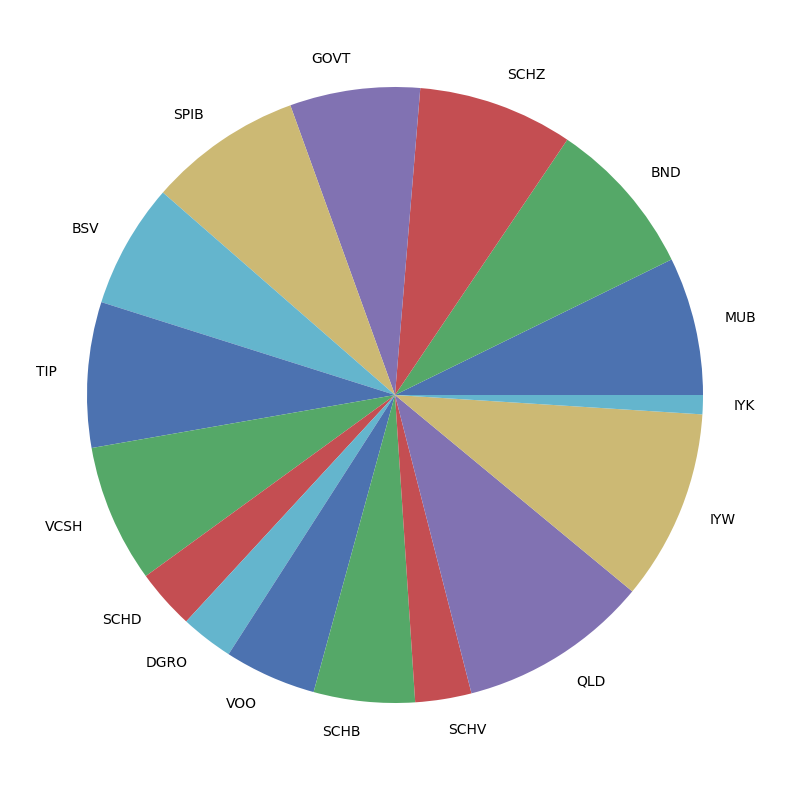

In [108]:
pd.Series(weights).plot.pie(figsize=(10,10));

In [109]:
da = DiscreteAllocation(weights, filtered_df.iloc[-1], total_portfolio_value=400000)
alloc, leftover = da.greedy_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc

Leftover: $5.90


{'QLD': 527,
 'IYW': 326,
 'BND': 466,
 'SCHZ': 1475,
 'SPIB': 1023,
 'TIP': 291,
 'MUB': 275,
 'VCSH': 389,
 'GOVT': 1220,
 'BSV': 350,
 'SCHB': 1153,
 'VOO': 45,
 'SCHD': 505,
 'SCHV': 525,
 'DGRO': 209,
 'IYK': 64}

# Portfolio Theory

In [110]:
stock_list = list(weights.keys())
stock_weights = list(weights.values())
portfolio = filtered_df[stock_list]
portfolio = np.log(portfolio / portfolio.shift(1))
portfolio.dropna(inplace=True)
portfolio

Ticker,MUB,BND,SCHZ,GOVT,SPIB,BSV,TIP,VCSH,AGG,BIV,...,SCHD,IYR,SDY,DGRO,VOO,SCHB,SCHV,QLD,IYW,IYK
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-03,0.002840,0.003898,0.003937,0.005618,0.002718,0.002286,0.005818,0.001921,0.004120,0.005019,...,-0.019781,0.006390,-0.012675,-0.023833,-0.024160,-0.023117,-0.016752,-0.069426,-0.047400,-0.012697
2019-01-04,-0.002656,-0.003016,-0.003739,-0.005215,-0.002718,-0.002541,-0.002087,-0.002691,-0.002995,-0.004528,...,0.027205,0.010649,0.022969,0.029253,0.032474,0.033737,0.028835,0.085836,0.044463,0.027649
2019-01-07,-0.000092,-0.001512,-0.000789,-0.002013,-0.000605,-0.001145,-0.000635,-0.000385,-0.001688,-0.000982,...,0.006740,0.010006,0.003999,0.004195,0.007475,0.008873,0.005390,0.019999,0.008412,0.004258
2019-01-08,-0.000734,-0.001262,0.000000,-0.002017,0.000000,-0.000892,0.000818,-0.000514,-0.000752,-0.001597,...,0.009402,0.018023,0.012340,0.008635,0.009668,0.010253,0.007537,0.019747,0.011046,0.012027
2019-01-09,-0.001102,0.001388,-0.000197,0.000000,0.002418,0.000892,0.001180,0.002181,0.000845,0.001843,...,0.000831,-0.001304,0.001313,0.002665,0.004610,0.005329,0.000790,0.014834,0.010196,-0.002833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,0.000832,-0.000668,-0.000645,-0.000870,0.000611,0.000716,-0.001953,0.000531,-0.001314,0.000197,...,0.006083,0.003310,0.004114,0.003368,0.002323,0.002165,0.004170,0.002781,0.001306,0.005343
2023-12-26,0.000369,0.000954,0.001075,0.000870,0.000305,-0.000651,0.000558,0.000000,0.002022,0.000262,...,0.004866,0.007572,0.004979,0.004845,0.004149,0.005212,0.005010,0.011568,0.005288,0.004999
2023-12-27,0.004053,0.006380,0.006212,0.005636,0.004571,0.002600,0.004549,0.002071,0.006342,0.007062,...,0.000787,0.005234,0.001841,0.001486,0.001829,0.001254,0.001427,0.003783,0.000000,0.002621


In [111]:
weights_series = pd.Series(weights)
weighted_returns = portfolio.mul(weights_series, axis=1)
portfolio_returns = weighted_returns.sum(axis=1)
# portfolio_monthly_returns = portfolio_returns.resample('M').apply(lambda x: (1 + x).prod() - 1)
# portfolio_monthly_returns.index = portfolio_monthly_returns.index.strftime('%Y-%m')
# portfolio_monthly_returns

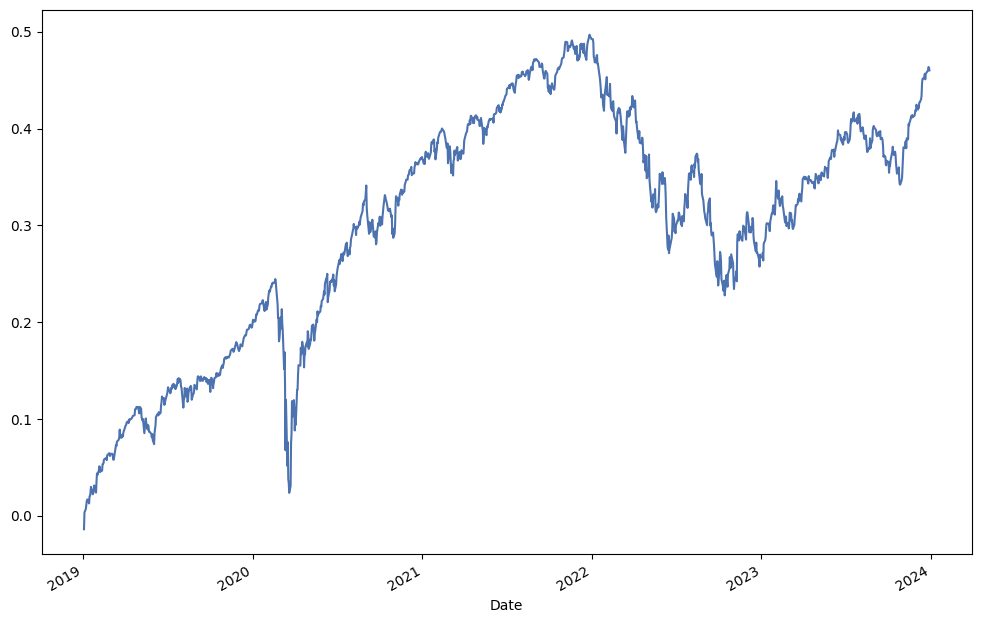

In [112]:
portfolio_returns.cumsum().plot(figsize=(12,8));

In [113]:
def get_factors(factors):
    factor_file = factors + ".csv"
    factor_df = pd.read_csv(factor_file)

    # Rename the first column to 'Date'
    factor_df = factor_df.rename(columns={'Unnamed: 0': 'Date'})

    # Check if the date format is monthly or daily
    if len(str(factor_df['Date'].iloc[0])) == 6:  # YYYYMM format (monthly)
        # Convert the date to YYYY-MM format
        factor_df['Date'] = factor_df['Date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m').strftime('%Y-%m'))
    else:  # Assuming YYYYMMDD format (daily)
        factor_df['Date'] = factor_df['Date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

    # Set the 'Date' column as the index
    factor_df = factor_df.set_index('Date')

    return factor_df

In [114]:
ff_factors_monthly = get_factors("F-F_Research_Data_Factors_daily")
ff_factors_monthly.head()

,Mkt-RF,SMB,HML,RF
Date,,,,
1926-07-01,0.10,-0.25,-0.27,0.009
1926-07-02,0.45,-0.33,-0.06,0.009
1926-07-06,0.17,0.30,-0.39,0.009
1926-07-07,0.09,-0.58,0.02,0.009
1926-07-08,0.21,-0.38,0.19,0.009


In [115]:
ff_factors_subset = ff_factors_monthly[
    ff_factors_monthly.index.isin(portfolio_returns.index)
].copy()

# Step 3: Calculate excess returns for the asset
ff_factors_subset["Excess_Return"] = portfolio_returns - ff_factors_subset["RF"]
ff_factors_subset

,Mkt-RF,SMB,HML,RF,Excess_Return
Date,,,,,
2019-01-03,-2.45,0.36,1.20,0.010,-0.023792
2019-01-04,3.55,0.41,-0.70,0.010,0.007336
2019-01-07,0.94,1.00,-0.75,0.010,-0.006332
2019-01-08,1.01,0.53,-0.63,0.010,-0.005362
2019-01-09,0.56,0.45,0.10,0.010,-0.006377
...,...,...,...,...,...
2023-12-22,0.20,0.64,0.10,0.021,-0.020025
2023-12-26,0.48,0.71,0.43,0.021,-0.018075
2023-12-27,0.16,0.14,0.10,0.021,-0.017583


In [116]:
X = sm.add_constant(ff_factors_subset[["Mkt-RF", "SMB", "HML"]])
y = ff_factors_subset["Excess_Return"]
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          Excess_Return   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.509
Method:                 Least Squares   F-statistic:                     435.0
Date:                Wed, 04 Dec 2024   Prob (F-statistic):          1.33e-193
Time:                        18:44:40   Log-Likelihood:                 4358.8
No. Observations:                1257   AIC:                            -8710.
Df Residuals:                    1253   BIC:                            -8689.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0069      0.000    -32.331      0.0

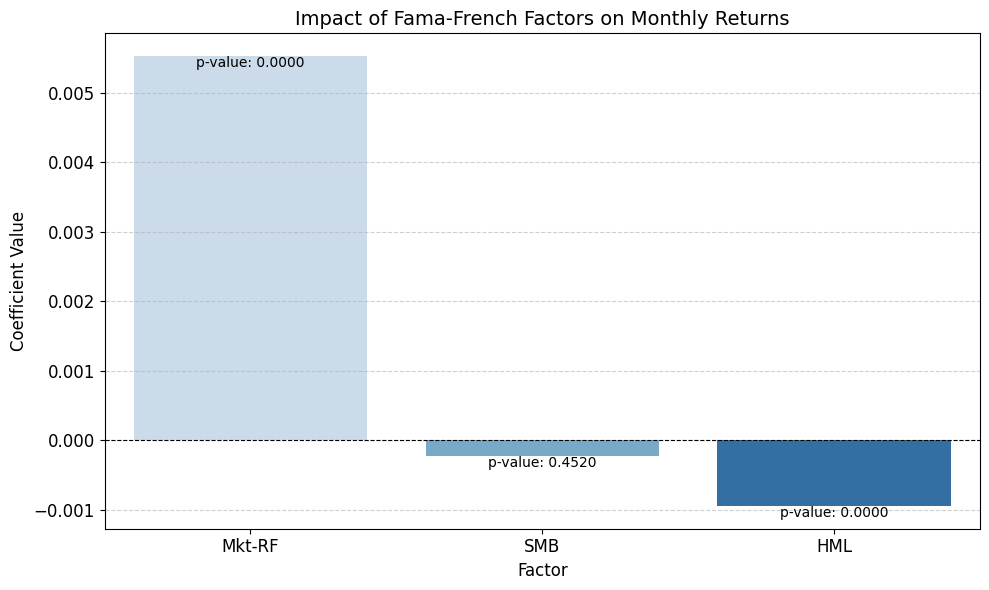

In [117]:
factors = model.params.index[1:]  # ['Mkt_Rf', 'SMB', 'HML']
coefficients = model.params.values[1:]
confidence_intervals = model.conf_int().diff(axis=1).iloc[1]

ols_data = pd.DataFrame(
    {
        "Factor": factors,
        "Coefficient": coefficients,
        "Confidence_Lower": confidence_intervals[0],
        "Confidence_Upper": confidence_intervals[1],
    }
)

plt.figure(figsize=(10, 6))

sns.barplot(x="Factor", y="Coefficient", data=ols_data, palette="Blues")

for i, row in ols_data.iterrows():
    plt.text(
        i,
        row['Coefficient'],
        f"p-value: {model.pvalues[row['Factor']]:.4f}",
        ha="center",
        va="top",
        fontsize=10,
        color="black",
    )

plt.title("Impact of Fama-French Factors on Monthly Returns", fontsize=14)
plt.xlabel("Factor", fontsize=12)
plt.ylabel("Coefficient Value", fontsize=12)

plt.axhline(0, color="black", linewidth=0.8, linestyle="--")
plt.grid(True, axis='y', linestyle='--', alpha=0.6)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()


# Scenario Analysis

In [118]:
from dataclasses import dataclass
from sensitivity import SensitivityAnalyzer

In [ ]:
start salary 75000
pro mo year 5 year n=1
cost raise 0.028
pro raise 0.16
saving rate 0.2
interest rate 5%
desired cash ????? Ko hỉu :)) cái cuoi

In [ ]:
@dataclass
class ModelInputs:
    starting_salary: int = 75000
    promos_every_n_years: int = 5
    cost_of_living_raise: float = 0.028
    promo_raise: float = 0.16
    savings_rate: float = 0.2
    interest_rate: float = 0.05
    desired_cash: int = 400000
        
model_data = ModelInputs()
model_data

ModelInputs(starting_salary=60000, promos_every_n_years=5, cost_of_living_raise=0.02, promo_raise=0.15, savings_rate=0.25, interest_rate=0.05, desired_cash=1500000)

In [120]:
def salary_at_year(data: ModelInputs, year):
    """
    Gets the salary at a given year from the start of the model based on cost of living raises and regular promotions.
    """
    # Every n years we have a promotion, so dividing the years and taking out the decimals gets the number of promotions
    num_promos = int(year / data.promos_every_n_years)
    salary_t = data.starting_salary * (1 + data.cost_of_living_raise) ** year * (1 + data.promo_raise) ** num_promos
    return salary_t

In [121]:
for i in range(6):
    year = i + 1
    salary = salary_at_year(model_data, year)
    print(f'The salary at year {year} is ${salary:,.0f}.')

The salary at year 1 is $61,200.
The salary at year 2 is $62,424.
The salary at year 3 is $63,672.
The salary at year 4 is $64,946.
The salary at year 5 is $76,182.
The salary at year 6 is $77,705.


In [122]:
def cash_saved_during_year(data: ModelInputs, year):
    """
    Calculated the cash saved within a given year, by first calculating the salary at that year then applying the 
    savings rate.
    """
    salary = salary_at_year(data, year)
    cash_saved = salary * data.savings_rate
    return cash_saved

In [123]:
def wealth_at_year(data: ModelInputs, year, prior_wealth):
    """
    Calculate the accumulated wealth for a given year, based on previous wealth, the investment rate,
    and cash saved during the year.
    """
    cash_saved = cash_saved_during_year(data, year)
    wealth = prior_wealth * (1 + data.interest_rate) + cash_saved
    return wealth

In [124]:
prior_wealth = 0  # starting with no cash saved
for i in range(6):
    year = i + 1
    wealth = wealth_at_year(model_data, year, prior_wealth)
    print(f'The wealth at year {year} is ${wealth:,.0f}.')
    
    # Set next year's prior wealth to this year's wealth
    prior_wealth = wealth

The wealth at year 1 is $15,300.
The wealth at year 2 is $31,671.
The wealth at year 3 is $49,173.
The wealth at year 4 is $67,868.
The wealth at year 5 is $90,307.
The wealth at year 6 is $114,248.


In [125]:
def years_to_retirement(data: ModelInputs, print_output=True):
    
    # starting with no cash saved
    prior_wealth = 0  
    wealth = 0
    
    year = 0
    
    if print_output:
        print('Wealths over time:')
    while wealth < data.desired_cash:
        year = year + 1
        wealth = wealth_at_year(data, year, prior_wealth)
        if print_output:
            print(f'The wealth at year {year} is ${wealth:,.0f}.')

        # Set next year's prior wealth to this year's wealth
        prior_wealth = wealth
        
    # Now we have exited the while loop, so wealth must be >= desired_cash. Whatever last year was set
    # is the years to retirement.
    if print_output:
        print(f'\nRetirement:\nIt will take {year} years to retire.')  # \n makes a blank line in the output.
    return year

In [126]:
years = years_to_retirement(model_data)

Wealths over time:
The wealth at year 1 is $15,300.
The wealth at year 2 is $31,671.
The wealth at year 3 is $49,173.
The wealth at year 4 is $67,868.
The wealth at year 5 is $90,307.
The wealth at year 6 is $114,248.
The wealth at year 7 is $139,775.
The wealth at year 8 is $166,975.
The wealth at year 9 is $195,939.
The wealth at year 10 is $229,918.
The wealth at year 11 is $266,080.
The wealth at year 12 is $304,542.
The wealth at year 13 is $345,431.
The wealth at year 14 is $388,878.
The wealth at year 15 is $439,025.
The wealth at year 16 is $492,294.
The wealth at year 17 is $548,853.
The wealth at year 18 is $608,878.
The wealth at year 19 is $672,557.
The wealth at year 20 is $745,168.
The wealth at year 21 is $822,190.
The wealth at year 22 is $903,859.
The wealth at year 23 is $990,422.
The wealth at year 24 is $1,082,140.
The wealth at year 25 is $1,185,745.
The wealth at year 26 is $1,295,520.
The wealth at year 27 is $1,411,793.
The wealth at year 28 is $1,534,910.

Reti

In [127]:
def get_salaries_wealths_df(data):
    """
    Runs the retirement model, collecting salary and wealth information year by year and storing
    into a DataFrame for further analysis.
    """
    # starting with no cash saved
    prior_wealth = 0  
    wealth = 0
    
    year = 0
    
    df_data_tups = []
    while wealth < data.desired_cash:
        year = year + 1
        salary = salary_at_year(data, year)
        wealth = wealth_at_year(data, year, prior_wealth)

        # Set next year's prior wealth to this year's wealth
        prior_wealth = wealth
        df_data_tups.append((year, salary, wealth))
        
    df = pd.DataFrame(df_data_tups, columns=['Year', 'Salary', 'Wealth'])
    
    return df

In [128]:
def styled_salaries_wealths(df):
    return df.style.format({
        'Salary': '${:,.2f}',
        'Wealth': '${:,.2f}'
    })

In [129]:
df = get_salaries_wealths_df(model_data)
styled_salaries_wealths(df)

,Year,Salary,Wealth
0,1,"$61,200.00","$15,300.00"
1,2,"$62,424.00","$31,671.00"
2,3,"$63,672.48","$49,172.67"
3,4,"$64,945.93","$67,867.79"
4,5,"$76,181.58","$90,306.57"
5,6,"$77,705.21","$114,248.20"
6,7,"$79,259.31","$139,775.44"
7,8,"$80,844.50","$166,975.33"
8,9,"$82,461.39","$195,939.45"
9,10,"$96,727.21","$229,918.22"


<Axes: xlabel='Year'>

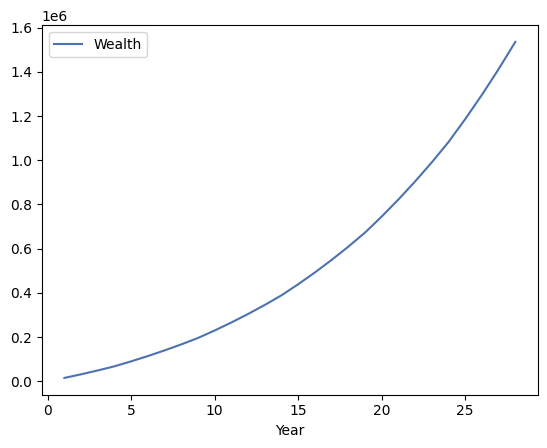

In [130]:
df.plot.line(x='Year', y='Wealth')

<Axes: xlabel='Year'>

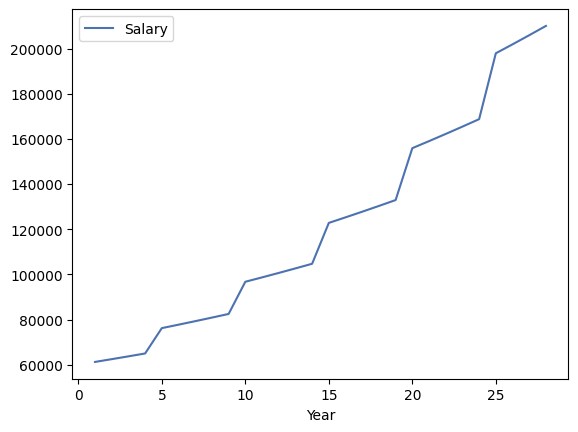

In [131]:
df.plot.line(x='Year', y='Salary')

In [132]:
def years_to_retirement_separate_args(
    starting_salary=60000, promos_every_n_years=5, cost_of_living_raise=0.02, 
    promo_raise=0.15, savings_rate=0.25, interest_rate=0.05, desired_cash=1500000
):
    data = ModelInputs(
        starting_salary=starting_salary, 
        promos_every_n_years=promos_every_n_years, 
        cost_of_living_raise=cost_of_living_raise, 
        promo_raise=promo_raise, 
        savings_rate=savings_rate, 
        interest_rate=interest_rate, 
        desired_cash=desired_cash
    )
    
    return years_to_retirement(data, print_output=False)

years_to_retirement_separate_args()

28

In [133]:
sensitivity_values = {
    'starting_salary': [i * 10000 for i in range(4, 8)],
    'promos_every_n_years': [i for i in range(4, 8)],
    'cost_of_living_raise': [i/100 for i in range(1, 4)],
    'promo_raise': [i/100 for i in range(10, 25, 5)],
    'savings_rate': [i/100 for i in range(10, 50, 10)],
    'interest_rate': [i/100 for i in range(3, 8)],
    'desired_cash': [i * 100000 for i in range(10, 26, 5)]
}

In [134]:
sa = SensitivityAnalyzer(
    sensitivity_values,
    years_to_retirement_separate_args,
    result_name='Years to Retirement',
    reverse_colors=True,
    grid_size=3
)

100%|██████████| 11520/11520 [00:07<00:00, 1489.59it/s]


In [135]:
sa.df

,starting_salary,promos_every_n_years,cost_of_living_raise,promo_raise,savings_rate,interest_rate,desired_cash,Years to Retirement
0,40000,4,0.01,0.1,0.1,0.03,1000000,52
1,40000,4,0.01,0.1,0.1,0.03,1500000,60
2,40000,4,0.01,0.1,0.1,0.03,2000000,66
3,40000,4,0.01,0.1,0.1,0.03,2500000,71
4,40000,4,0.01,0.1,0.1,0.04,1000000,47
...,...,...,...,...,...,...,...,...
11515,70000,7,0.03,0.2,0.4,0.06,2500000,25
11516,70000,7,0.03,0.2,0.4,0.07,1000000,16
11517,70000,7,0.03,0.2,0.4,0.07,1500000,19
11518,70000,7,0.03,0.2,0.4,0.07,2000000,22


In [136]:
bad_economy_data = ModelInputs(
    starting_salary=40000,
    promos_every_n_years=8,
    cost_of_living_raise=0.01,
    promo_raise=0.07,
    savings_rate=0.15,
    interest_rate=0.03,
)

good_economy_data = ModelInputs(
    starting_salary=70000,
    promos_every_n_years=4,
    cost_of_living_raise=0.03,
    promo_raise=0.20,
    savings_rate=0.35,
    interest_rate=0.06,
)

cases = {
    'Bad': bad_economy_data,
    'Normal': model_data, # Original inputs were set to assume a normal economy
    'Good': good_economy_data
}

In [137]:
for case_type, case_inputs in cases.items():
    ytr = years_to_retirement(case_inputs, print_output=False)
    print(f'It would take {ytr} years to retire in a {case_type} economy.')

It would take 61 years to retire in a Bad economy.
It would take 28 years to retire in a Normal economy.
It would take 19 years to retire in a Good economy.


In [138]:
case_probabilities = {
    'Bad': 0.2,
    'Normal': 0.5,
    'Good': 0.3
}

# Take expected value over the cases
expected_ytr = 0
for case_type, case_inputs in cases.items():
    ytr = years_to_retirement(case_inputs, print_output=False)
    weighted_ytr = ytr * case_probabilities[case_type]
    expected_ytr += weighted_ytr
print(f'It would take {expected_ytr:.0f} years to retire considering a {case_probabilities["Bad"]:.0%} chance of a bad economy and {case_probabilities["Good"]:.0%} chance of a good economy.')

It would take 32 years to retire considering a 20% chance of a bad economy and 30% chance of a good economy.


# Evaluation

In [139]:
list(portfolio.columns)

['MUB',
 'BND',
 'SCHZ',
 'GOVT',
 'SPIB',
 'BSV',
 'TIP',
 'VCSH',
 'AGG',
 'BIV',
 'FBND',
 'BOND',
 'TLT',
 'PFF',
 'SCHD',
 'IYR',
 'SDY',
 'DGRO',
 'VOO',
 'SCHB',
 'SCHV',
 'QLD',
 'IYW',
 'IYK']

In [140]:
port_data = {}
start_date = '2023-12-31'
end_date = '2024-11-26'

for ticker in portfolio.columns:
    print(f"Fetching data for ticker: {ticker}")
    port_data[ticker] = yfinance_adj_close(ticker, start=start_date, end=end_date)

portfolio_df = pd.concat(port_data.values(), axis=1)
portfolio_df.ffill(inplace=True)
portfolio_df.bfill(inplace=True)
portfolio_df.columns = portfolio.columns
portfolio_df

Fetching data for ticker: MUB
Fetching data for ['MUB'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: BND
Fetching data for ['BND'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: SCHZ
Fetching data for ['SCHZ'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: GOVT
Fetching data for ['GOVT'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: SPIB
Fetching data for ['SPIB'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: BSV
Fetching data for ['BSV'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: TIP
Fetching data for ['TIP'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: VCSH
Fetching data for ['VCSH'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: AGG
Fetching data for ['AGG'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: BIV
Fetching data for ['BIV'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: FBND
Fetching data for ['FBND'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: BOND
Fetching data for ['BOND'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: TLT
Fetching data for ['TLT'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: PFF
Fetching data for ['PFF'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: SCHD
Fetching data for ['SCHD'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: IYR
Fetching data for ['IYR'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: SDY
Fetching data for ['SDY'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: DGRO
Fetching data for ['DGRO'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: VOO
Fetching data for ['VOO'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: SCHB
Fetching data for ['SCHB'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: SCHV
Fetching data for ['SCHV'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: QLD
Fetching data for ['QLD'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: IYW
Fetching data for ['IYW'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Fetching data for ticker: IYK
Fetching data for ['IYK'] from 2023-12-31 to 2024-11-26 with interval '1d'


[*********************100%%**********************]  1 of 1 completed


Ticker,MUB,BND,SCHZ,GOVT,SPIB,BSV,TIP,VCSH,AGG,BIV,...,SCHD,IYR,SDY,DGRO,VOO,SCHB,SCHV,QLD,IYW,IYK
Date,,,,,,,,,,,,,,,,,,,,,
2024-01-02,105.343620,70.859726,21.962708,22.317286,31.422766,74.512352,104.827728,74.438904,95.204544,73.502266,...,25.070749,90.660507,122.577904,53.071957,429.748047,18.263172,22.534845,73.277695,119.299126,63.803226
2024-01-03,105.392273,70.917786,21.991102,22.356148,31.403561,74.531754,104.993736,74.390671,95.252739,73.550591,...,24.913834,88.497711,121.356819,52.786839,426.559631,18.074961,22.336161,71.711166,118.091370,63.547775
2024-01-04,105.294960,70.598495,21.891724,22.249273,31.317129,74.434769,104.505440,74.332802,94.867210,73.231644,...,24.884411,88.340416,121.122360,52.757339,425.213013,18.032036,22.316933,70.922913,117.282860,63.423321
2024-01-05,105.158745,70.385643,21.830202,22.181263,31.269108,74.376595,104.271049,74.274933,94.645538,72.990013,...,24.966139,88.143799,121.229828,52.777004,425.757599,18.051846,22.377821,71.102516,117.402641,63.194073
2024-01-08,105.528496,70.695244,21.920113,22.249273,31.355537,74.492966,104.554283,74.409958,95.002136,73.250984,...,25.113249,89.411987,122.079704,53.180107,431.847229,18.322607,22.515619,74.016060,120.516869,63.515022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-19,107.322365,72.459785,22.897940,22.617743,32.878952,77.180099,107.691536,77.988358,97.582123,75.282021,...,28.639999,99.120003,139.720001,63.000000,542.700012,22.940001,27.190001,105.809998,158.139999,68.370003
2024-11-20,107.322365,72.380028,22.858067,22.587824,32.829140,77.130249,107.641624,77.948494,97.482437,75.172371,...,28.709999,98.910004,139.619995,63.040001,542.900024,22.959999,27.230000,105.680000,157.910004,68.750000
2024-11-21,107.272491,72.340149,22.848097,22.567877,32.809212,77.080391,107.501877,77.898666,97.432587,75.122528,...,28.980000,99.620003,141.279999,63.770000,545.640015,23.120001,27.580000,106.449997,158.970001,69.400002


In [141]:
returns_df = portfolio_df.pct_change().dropna()
port_retss = returns_df.sum(axis=1)

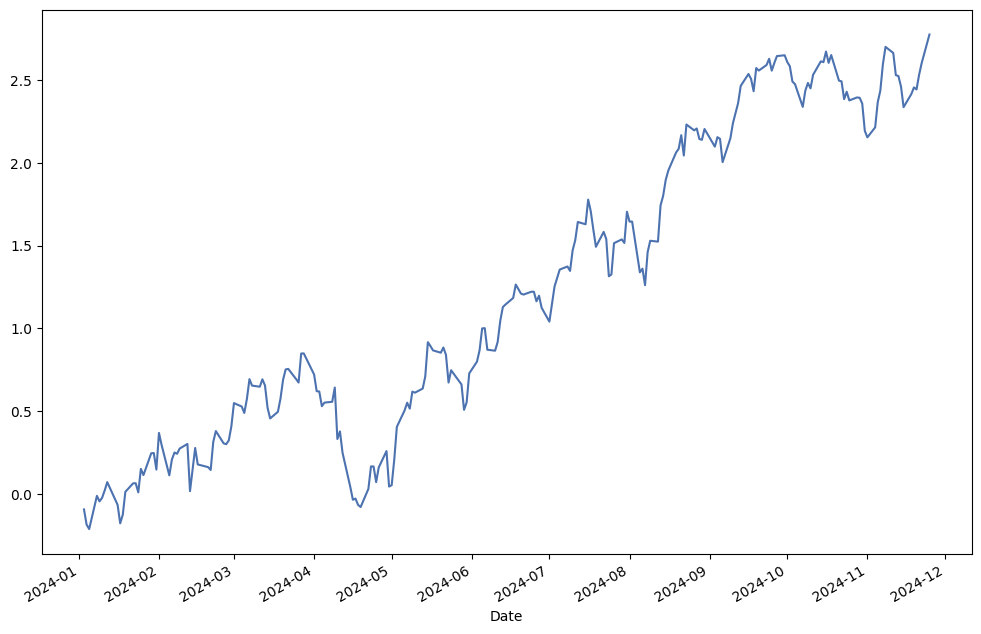

In [142]:
port_retss.cumsum().plot(figsize=(12,8));

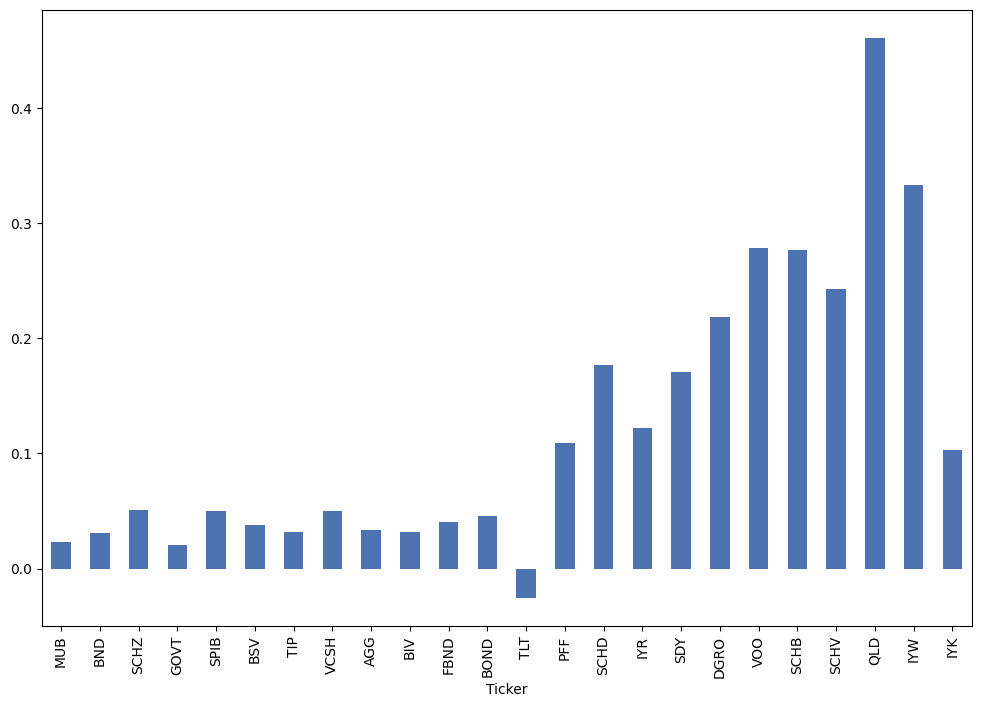

In [143]:
cumulative_returns_df = (1 + returns_df).prod() - 1
cumulative_returns_df.plot(kind='bar', figsize=(12,8));

In [144]:
ticker = "^IRX"

start_date = "2022-01-01"
end_date = "2024-11-26"

rf = yf.download(ticker, start=start_date, end=end_date)
rf = rf[['Adj Close']]
rf = rf.rename(columns={'Adj Close': 'rf'})
rolling_rf = rf.rolling(window=252).mean()
rolling_rf

[*********************100%%**********************]  1 of 1 completed


,rf
Date,
2022-01-03,NaN
2022-01-04,NaN
2022-01-05,NaN
2022-01-06,NaN
2022-01-07,NaN
...,...
2024-11-19,5.058925
2024-11-20,5.055639
2024-11-21,5.052298


In [145]:
rolling_rf.iloc[-1].values

array([5.0455595])

[*********************100%%**********************]  1 of 1 completed


Portfolio Performance Metrics:
Annualized Sharpe Ratio: 1.33
Annualized Jensen Alpha: -1.28%

Attribution Analysis:
Allocation Effects: 0.06%
Selection Effects: 15.59%


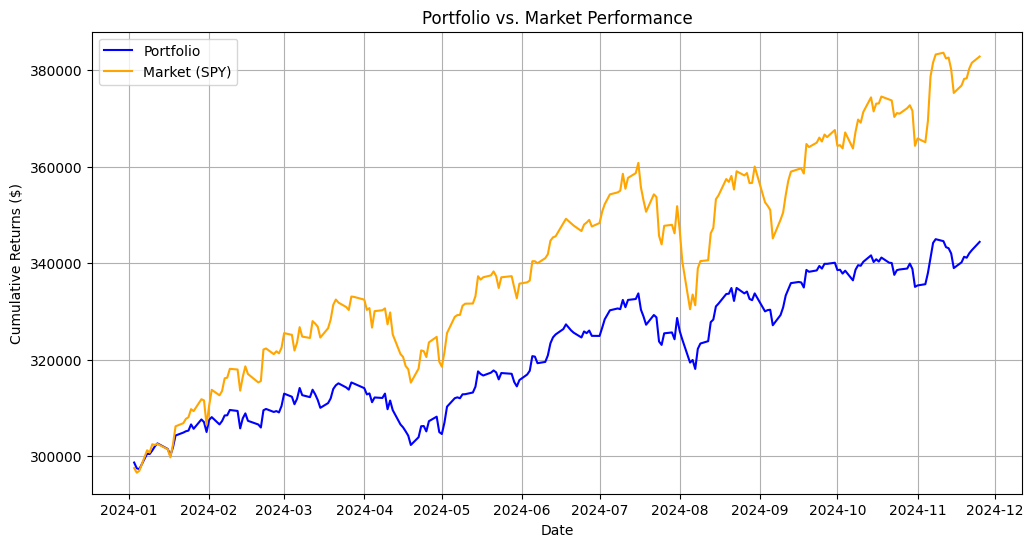

In [146]:
start_date = '2023-12-31'
end_date = '2024-11-26'
# Market data (e.g., S&P 500 as market benchmark)
market_prices = yf.download("SPY", start=start_date, end=end_date)["Adj Close"]

# Portfolio returns (weighted daily returns based on portfolio_df and stock_weights)
port_retss = (portfolio_df.pct_change() @ stock_weights).dropna()  # Weighted daily returns

# Initial money
initial_money = 300000

# Constants
trading_days_per_year = 252
risk_free_rate_annual = (rolling_rf.iloc[-1].values)/100  # 2% annual risk-free rate

# Step 1: Calculate cumulative portfolio returns starting from initial money
portfolio_cum_returns = (1 + port_retss).cumprod() * initial_money  # Adjust cumulative returns

# Step 2: Calculate market returns
market_returns = market_prices.pct_change().dropna()

# Step 3: Sharpe Ratio (Annualized)
risk_free_rate_daily = risk_free_rate_annual / trading_days_per_year
excess_returns = port_retss - risk_free_rate_daily
sharpe_ratio = (excess_returns.mean() * trading_days_per_year) / (port_retss.std() * np.sqrt(trading_days_per_year))

# Step 4: Jensen's Alpha (Annualized)
slope, intercept, _, _, _ = linregress(market_returns, port_retss)
jensen_alpha_daily = intercept
jensen_alpha = jensen_alpha_daily * trading_days_per_year

# Step 5: Attribution Analysis
allocation_effects = portfolio_df.pct_change().mean() * stock_weights
selection_effects = port_retss.mean() * trading_days_per_year - allocation_effects.sum()

# Display Results
print("Portfolio Performance Metrics:")
print(f"Annualized Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Annualized Jensen Alpha: {jensen_alpha:.2%}")

print("\nAttribution Analysis:")
print(f"Allocation Effects: {allocation_effects.sum():.2%}")
print(f"Selection Effects: {selection_effects:.2%}")

# Step 6: Plot Portfolio vs. Market
plt.figure(figsize=(12, 6))
plt.plot(portfolio_cum_returns, label="Portfolio", color="blue")
plt.plot((1 + market_returns).cumprod() * initial_money, label="Market (SPY)", color="orange")  # Adjusted market cumulative returns
plt.legend()
plt.title("Portfolio vs. Market Performance")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns ($)")
plt.grid()
plt.show()

In [147]:
beta, _, _, _, _ = linregress(market_returns, port_retss)
print(f"Beta: {beta:.2f}")

Beta: 0.61


In [148]:
rolling_max = portfolio_cum_returns.cummax()
drawdown = (portfolio_cum_returns - rolling_max) / rolling_max
max_drawdown = drawdown.min()
print(f"Maximum Drawdown: {max_drawdown:.2%}")

Maximum Drawdown: -4.69%


In [149]:
downside_returns = port_retss[port_retss < 0]
sortino_ratio = excess_returns.mean() / downside_returns.std()
print(f"Sortino Ratio: {sortino_ratio:.2f}")

Sortino Ratio: 0.13


In [156]:
annualized_return = (portfolio_cum_returns.iloc[-1] / portfolio_cum_returns.iloc[0]) ** (252 / len(port_retss)) - 1
print(f"Annualized Return: {annualized_return:.2%}")

Annualized Return: 17.13%


In [151]:
correlation = port_retss.corr(market_returns)
print(f"Correlation with Market: {correlation:.2f}")

Correlation with Market: 0.95


In [152]:
portfolio_volatility = port_retss.std() * (252 ** 0.5)  # Annualized volatility
print(f"Portfolio Volatility: {portfolio_volatility:.2%}")

Portfolio Volatility: 8.01%


In [153]:
treynor_ratio = excess_returns.mean() / beta
print(f"Treynor Ratio: {treynor_ratio:.2f}")

Treynor Ratio: 0.00


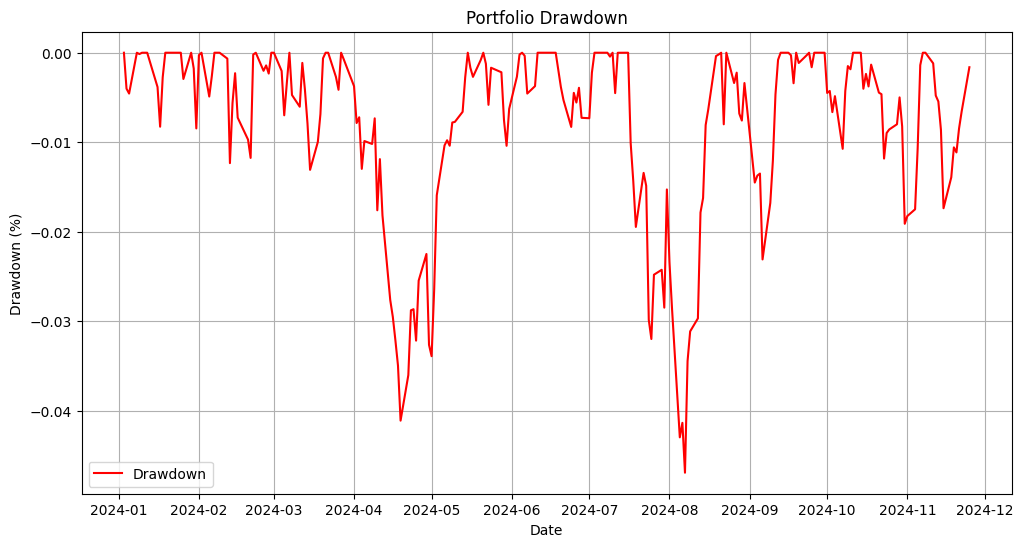

In [154]:
plt.figure(figsize=(12, 6))
plt.plot(drawdown, label="Drawdown", color="red")
plt.title("Portfolio Drawdown")
plt.xlabel("Date")
plt.ylabel("Drawdown (%)")
plt.grid()
plt.legend()
plt.show()

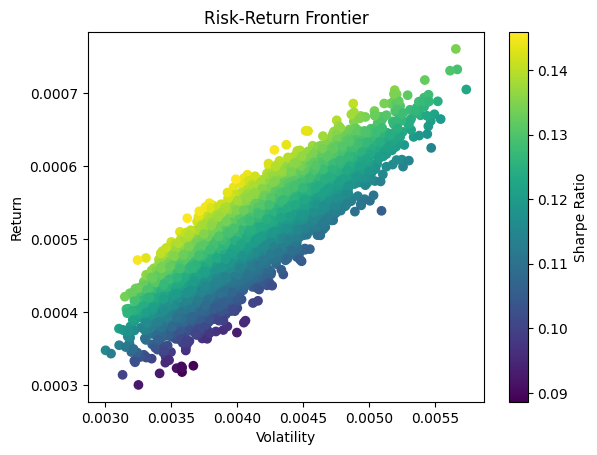

In [155]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Mean returns and covariance matrix for stocks
mean_returns = portfolio_df.pct_change().mean()
cov_matrix = portfolio_df.pct_change().cov()

# Constraints and bounds for optimization (weights sum to 1, each weight is between 0 and 1)
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
bounds = tuple((0, 1) for _ in range(len(mean_returns)))

# Random portfolio optimization
num_portfolios = 10000
results = np.zeros((3, num_portfolios))
for i in range(num_portfolios):
    weights = np.random.random(len(mean_returns))
    weights /= np.sum(weights)
    portfolio_return = np.sum(weights * mean_returns)
    portfolio_stddev = portfolio_volatility(weights, mean_returns, cov_matrix)
    results[0, i] = portfolio_return
    results[1, i] = portfolio_stddev
    results[2, i] = (portfolio_return / portfolio_stddev)  # Sharpe Ratio

# Plot the efficient frontier
plt.scatter(results[1], results[0], c=results[2], cmap='viridis')
plt.colorbar(label="Sharpe Ratio")
plt.xlabel("Volatility")
plt.ylabel("Return")
plt.title("Risk-Return Frontier")
plt.show()